# POPPY Simulation: MagAO-X for PDR (Version: No FITS surfaces used)
<b>Note</b>: This file does not include the FITS files used for the optical surfaces.

<b>Note</b>: all F/# PSFs after telescope F/11 in this notebook are not corrected because the correction distance is very small (range: 10<sup>-5</sup> to 10<sup>-7</sup> meters). For full F/# focal plane correction analysis, please go here: https://github.com/jlumbres/magaox_poppy/blob/master/magaox_pdr_all-FP-corrected.ipynb 

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope (all elements and distances before F/11 focal plane) pulled from Oli Durney's MagAO-X Zemax file.
- MagAO-X values (after F/11 focal plane) pulled from Laird Close's MagAO-X design spreadsheet (January 2017)

### Optical elements not implemented currently:
- ADC1 (surface 4&5, 7&8)
- ADC2 (surface 6&7, 9&10)

### To-do Tasks:
- Incorporate PSD into POPPY via FITS file (see: https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html)

In [2]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # this may change in the future.
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
lyot_stop_diam = 0.009 * u.m

# radius of curvature values
M1_roc = 16.26 * u.m
M2_roc = 2.862820 * u.m
fl_M1 = 8.128 * u.m
fl_M2 = M2_roc/2

# propagation distances
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_f11fp = 4.979516 * u.m
d_f11fp_correction = 0.027078594 * u.m # This value is calculated separately in another file. See mag_telescope.ipynb for origin.
d_f11fp_oap0 = 0.1434399617 * u.m
d_oap0_woofer = 0.14437519 * u.m
d_woofer_oap1 = 0.2107263437 * u.m
d_oap1_asmfp = 0.2107263437 * u.m
d_asmfp_oap2 = 0.3136327727 * u.m
d_oap2_tweeter = 0.3136327727 * u.m
d_tweeter_oap3 = 1.106254211 * u.m
d_oap3_f57fp = 1.106254211 * u.m
d_f57fp_oap4 = 0.513 * u.m
d_oap4_ttmirror = 0.513 * u.m
d_ttmirror_oap51 = 0.621 * u.m
d_oap51_f69fp = 0.621 * u.m
d_f69fp_oap52 = 0.621 * u.m
d_oap52_lyot = 0.621 * u.m
d_lyot_oap53 = 0.621 * u.m
d_oap53_f69sci = 0.621 * u.m

# OAP mirrors
# All focal lengths are the FS (vertex focus) values in Laird's excel spreadsheet
OAP0 = poppy.QuadraticLens(0.1434399616742 * u.m, name='OAP-0')
OAP1 = poppy.QuadraticLens(0.2107263436959 * u.m, name='OAP-1')
OAP2 = poppy.QuadraticLens(0.3136327726755 * u.m, name='OAP-2')
OAP3 = poppy.QuadraticLens(1.1062542105511 * u.m, name='OAP-3')
OAP4 = poppy.QuadraticLens(0.513 * u.m, name='OAP-4')
OAP5 = poppy.QuadraticLens(0.621 * u.m, name='OAP-5')

M1 = poppy.QuadraticLens(fl_M1, name='M1')
M2 = poppy.QuadraticLens(fl_M2, name='M2')

lyotstop = poppy.CircularAperture(radius=lyot_stop_diam/2, name='Lyot Stop')

## Begin Magellan Telescope

In [3]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)

# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
magaox.add_optic(poppy.SecondaryObscuration(secondary_radius=0.29*3.25, support_width=0.050, support_angle_offset=45.0))

# Surface -6: Primary Mirror
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

# Surface -5: Secondary Mirror
magaox.add_optic(M2, distance=d_m1_m2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M3 (flat)"), distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (uncorrected)"), distance=d_m3_f11fp+d_f11fp_correction)

### F/11 PSF
Commented out this section to skip building PSF at F/11

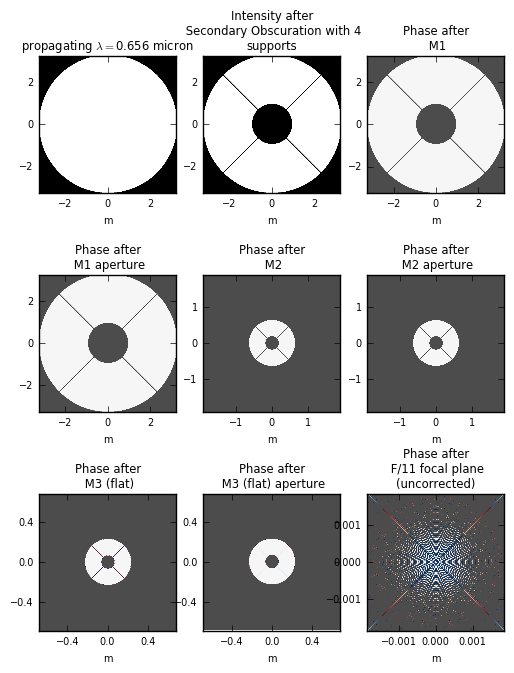

In [4]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[6,8])
f11fp_psf, f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

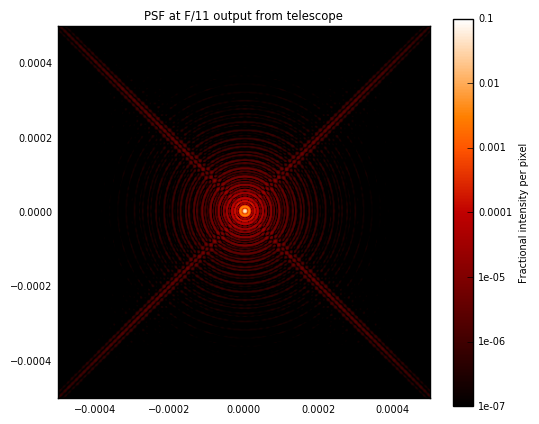

In [5]:
# Check out F/11 focal plane PSF
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf, imagecrop=0.001)
plt.title("PSF at F/11 output from telescope")

## Begin MagAO-X Design
### Build to F/16 ASM Focal Plane (Surface 1)

In [6]:
# Surface -2: OAP-0
magaox.add_optic(OAP0, distance=d_f11fp_oap0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Surface -1: woofer mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer mirror"), distance=d_oap0_woofer)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="woofer mirror aperture"))

# Surface 0: OAP-1
magaox.add_optic(OAP1, distance=d_woofer_oap1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface 1: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane"), distance=d_oap1_asmfp)

### ASM F/16 PSF
2017/03/29 5:55 PM Arizona time - IGNORE FROM THIS POINT ON

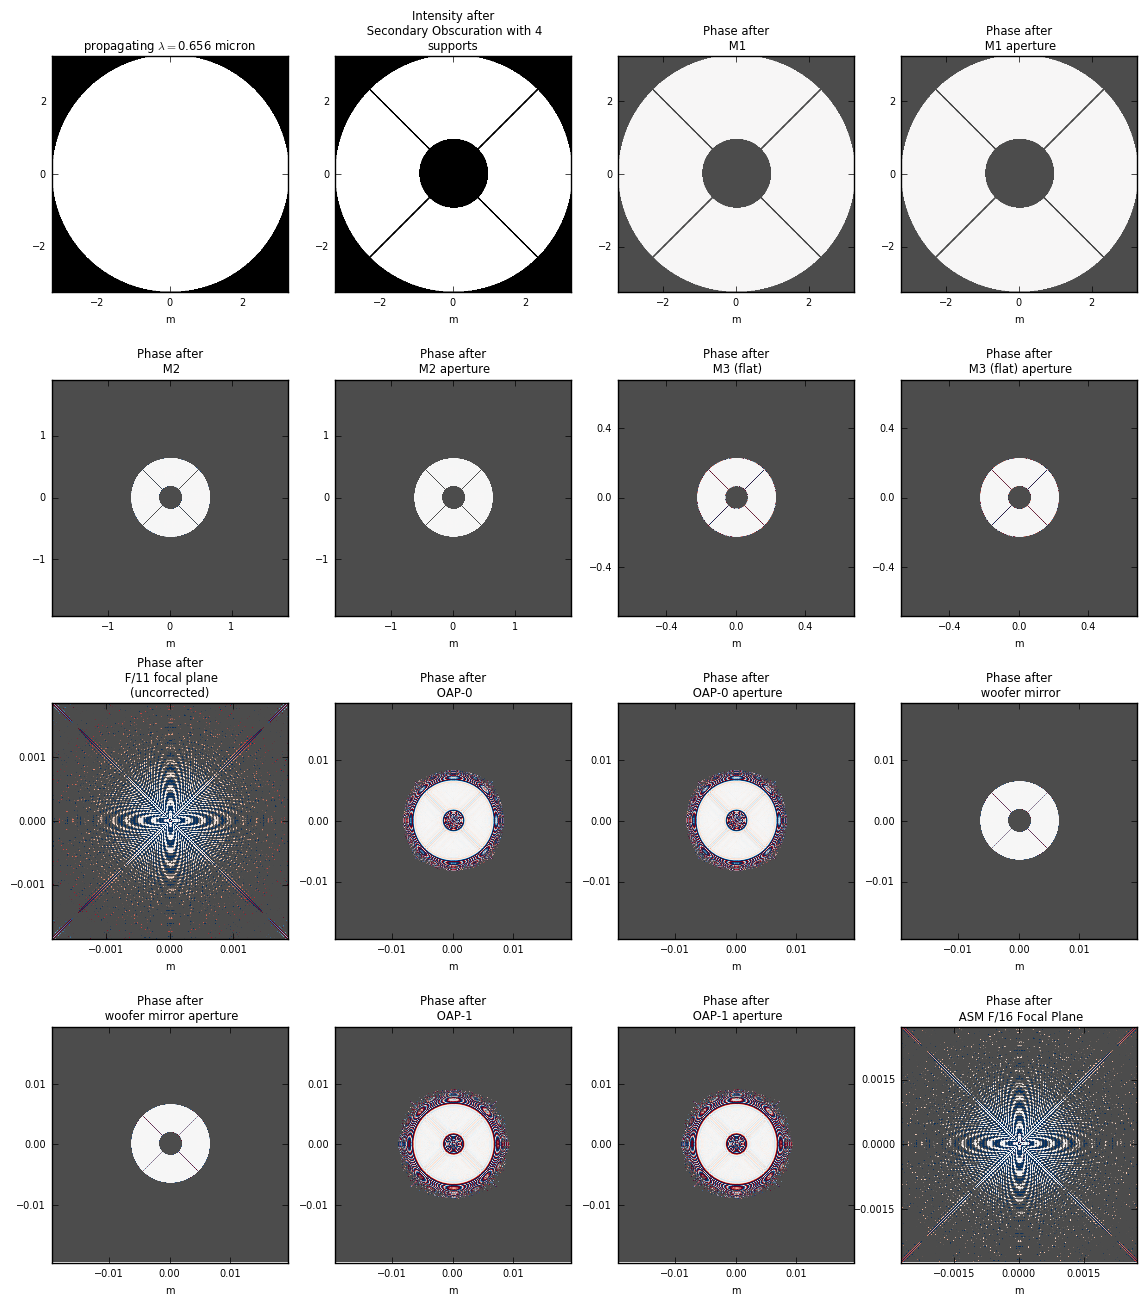

In [7]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[14,16])
asm_psf, asm_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

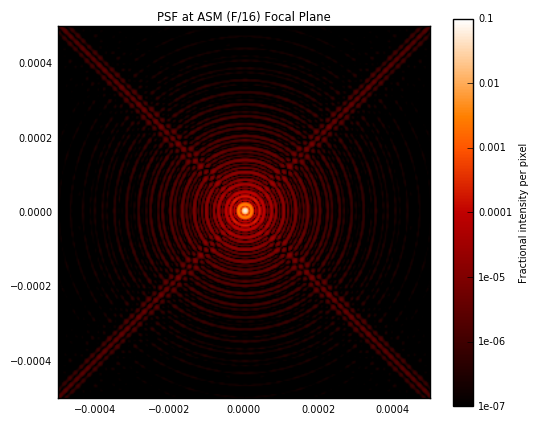

In [8]:
plt.figure(figsize=[6,5])
poppy.display_PSF(asm_psf, imagecrop=0.001)
plt.title("PSF at ASM (F/16) Focal Plane")

### Build to F/57 Focal Plane (Surface 5)

In [9]:
# Surface 2: OAP-2
magaox.add_optic(OAP2, distance=d_asmfp_oap2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface 3: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter mirror"), distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="tweeter mirror aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface 4: OAP-3
magaox.add_optic(OAP3, distance=d_tweeter_oap3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface 5: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane"), distance=d_oap3_f57fp)

### F/57 PSF

In [10]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[12,14])
f57_psf, f57_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

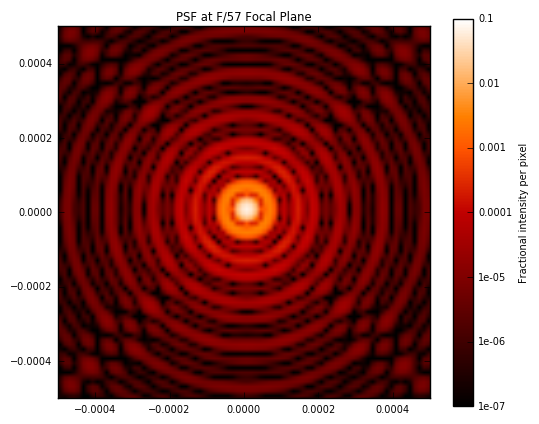

In [11]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f57_psf, imagecrop=0.001)
plt.title("PSF at F/57 Focal Plane")

### Build to F/69 Focal Plane (Surface 13)

In [12]:
# Surface 6: OAP-4
magaox.add_optic(OAP4, distance=d_f57fp_oap4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface 11: flat TT mirror (9mm pupil)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm pupil flat TT mirror"), distance=d_oap4_ttmirror)
magaox.add_optic(poppy.CircularAperture(radius=0.0045*u.m, name="woofer mirror aperture"))

# Surface 12: OAP-5.1
magaox.add_optic(OAP5, distance=d_ttmirror_oap51)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #1 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_oap51_f69fp)

### F/69 PSF

In [13]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
f69_psf, f69_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

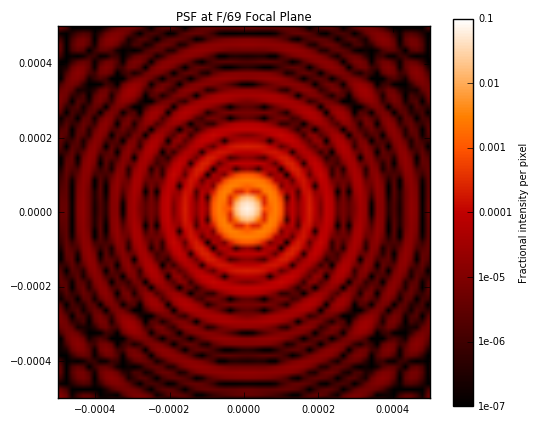

In [14]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69_psf, imagecrop=0.001)
plt.title("PSF at F/69 Focal Plane")

### Build to Science F/69 Focal Plane

In [15]:
# Surface 14: OAP-5.2
magaox.add_optic(OAP5, distance=d_f69fp_oap52)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #2 aperture"))

# Surface 15: 9mm Lyot Stop
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm Lyot Stop"), distance=d_oap52_lyot)
magaox.add_optic(lyotstop)

# Surface 16: OAP-5.3
magaox.add_optic(OAP5, distance=d_lyot_oap53)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #3 aperture"))

# Surface 17: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_oap53_f69sci)

## MagAO-X Optical Element Phase Values

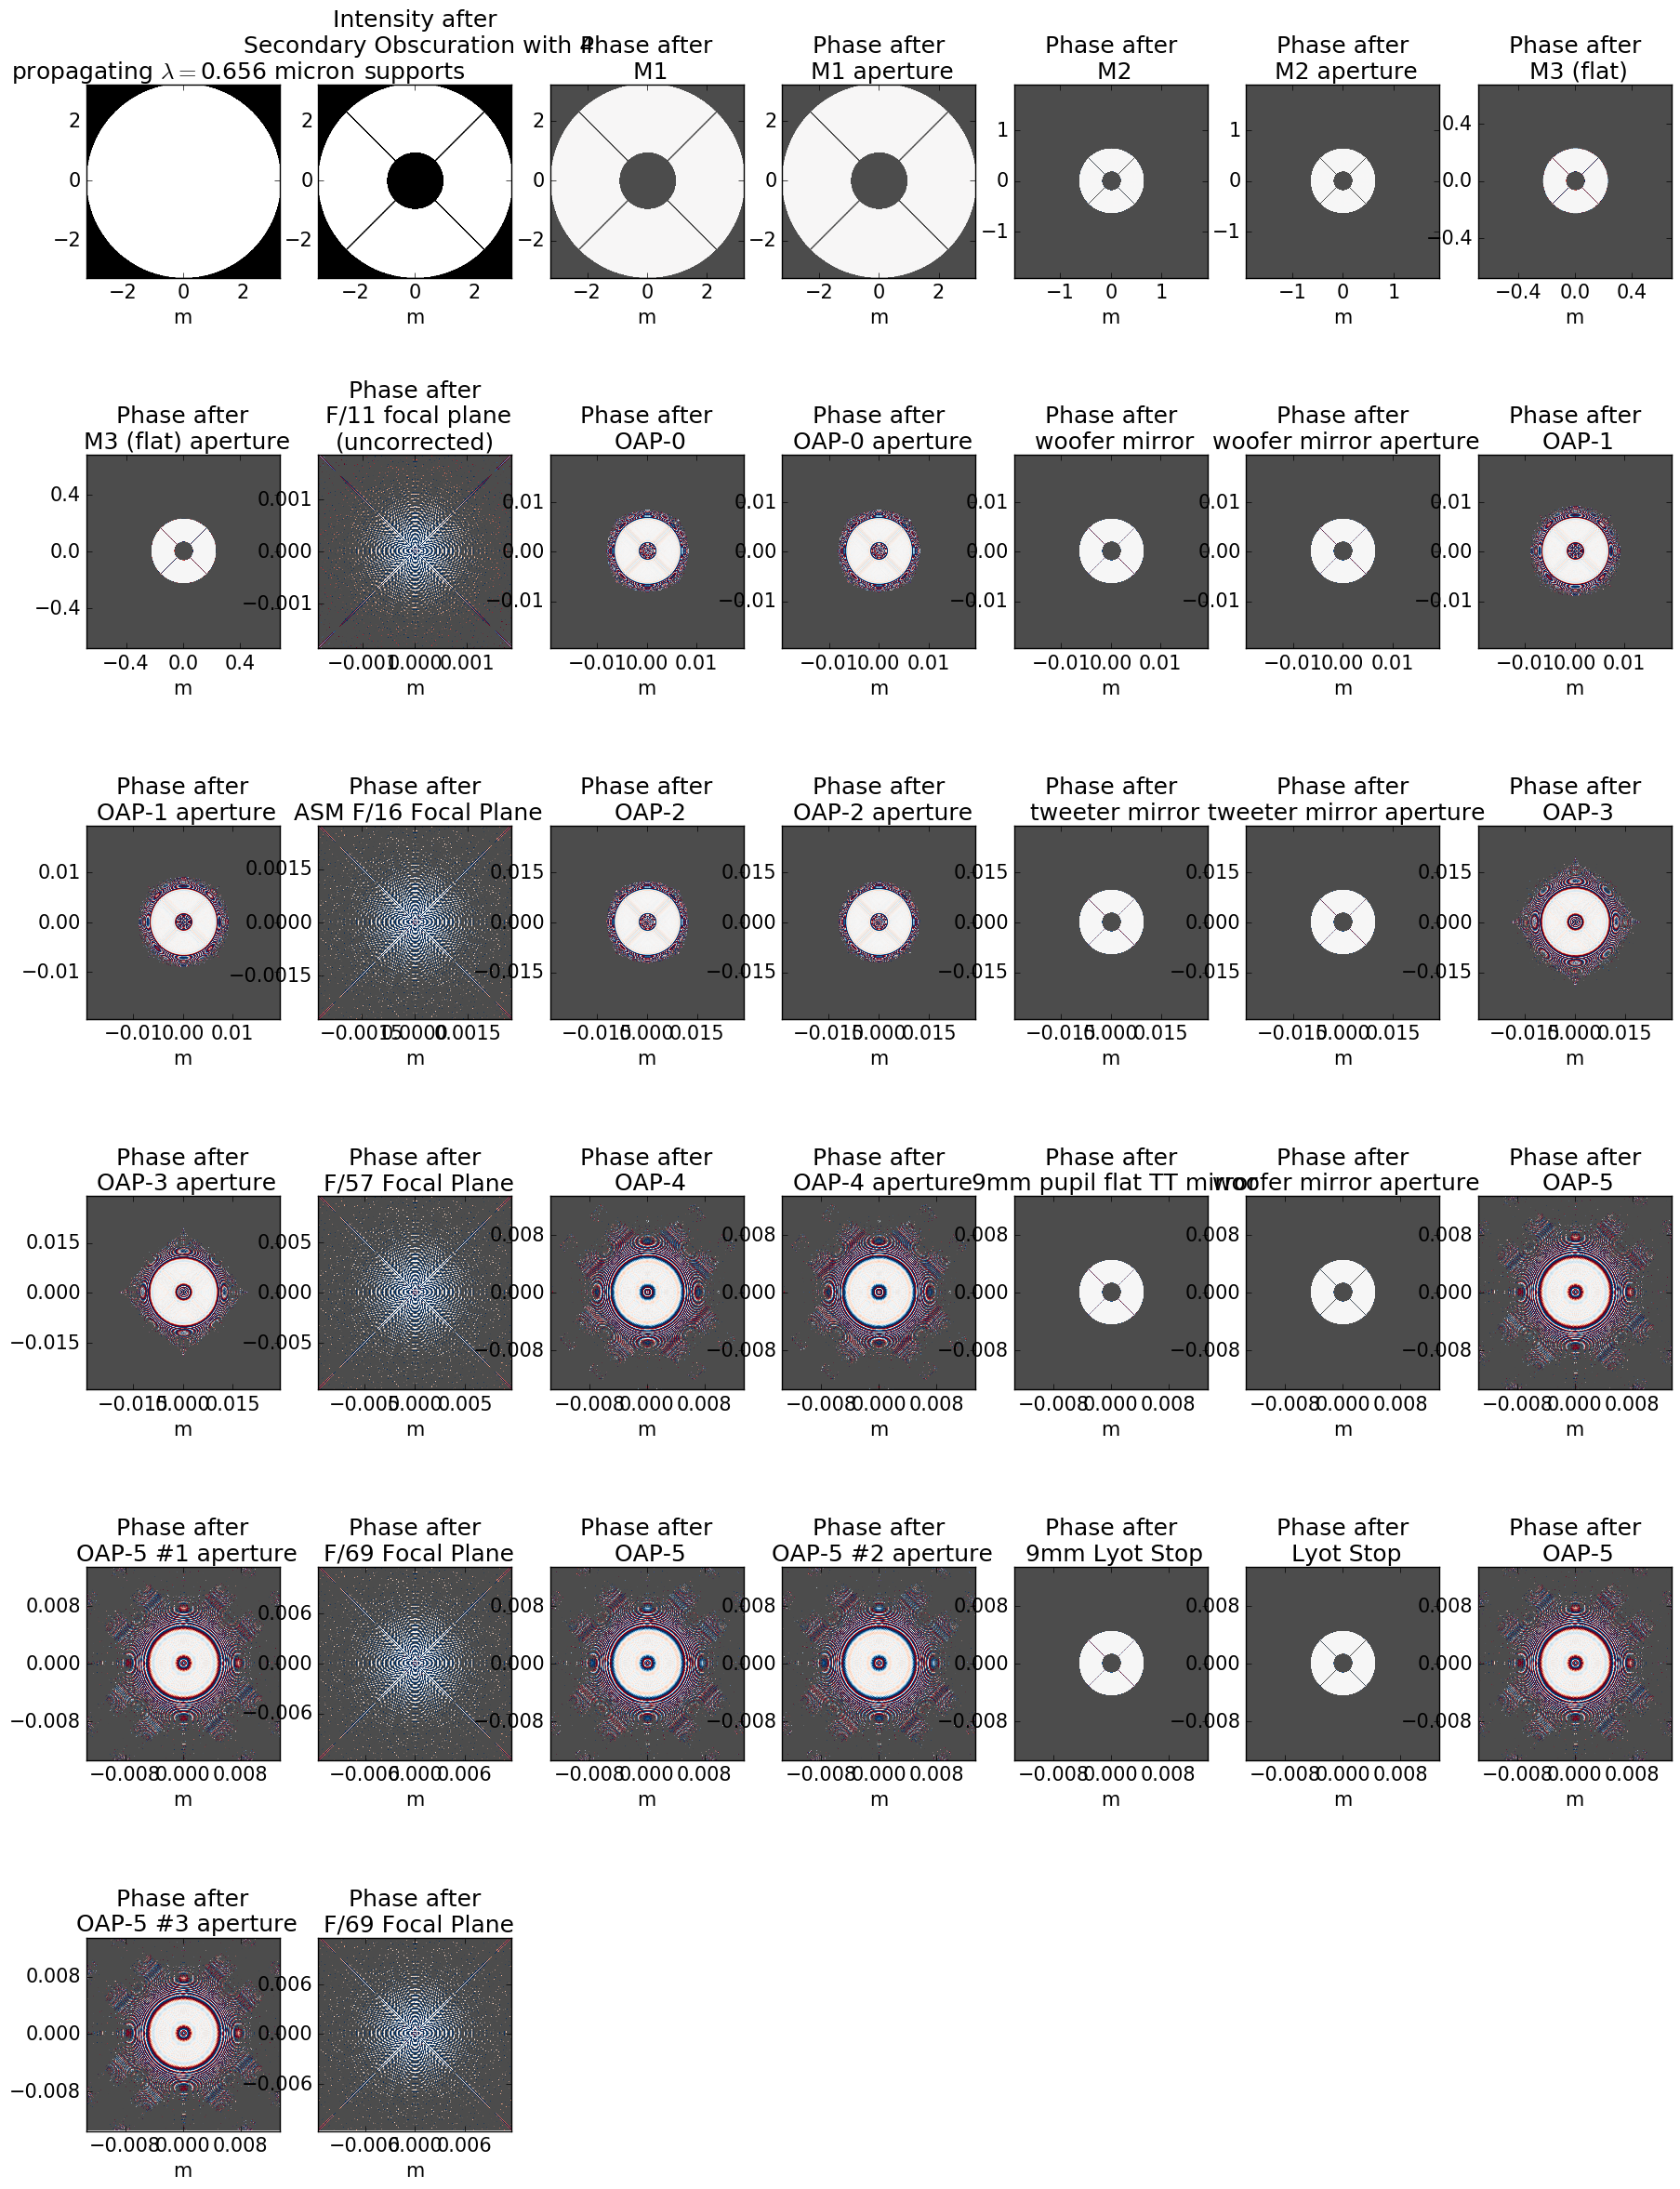

In [16]:
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=[22,30])
f69sci_psf, f69sci_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

## F/69 Science PSF

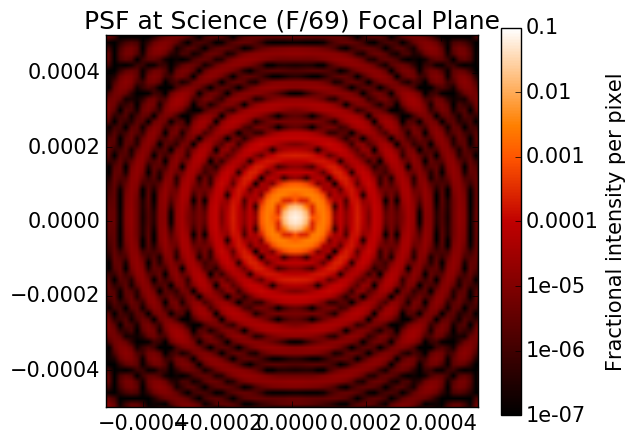

In [17]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69sci_psf, imagecrop=0.001)
plt.title("PSF at Science (F/69) Focal Plane")

## MagAO-X System Description

In [18]:
magaox.describe()

	Entrance pupil diam:  6.478408 m	npix: 512	Beam ratio:0.34
	Optic: Circle, radius=3.239204 m
	Pupil plane: Secondary Obscuration with 4 supports (Analytic)
	Lens: M1, with focal length 8.128 m
	Optic: M1 aperture
	Propagation distance:  9.72205 m
	Lens: M2, with focal length 1.43141 m
	Optic: M2 aperture
	Propagation distance:  9.02279 m
	Optic: M3 (flat)
	Optic: M3 (flat) aperture
	Propagation distance:  5.006594594 m
	Optic: F/11 focal plane (uncorrected)
	Propagation distance:  0.1434399617 m
	Lens: OAP-0, with focal length 0.1434399616742 m
	Optic: OAP-0 aperture
	Propagation distance:  0.14437519 m
	Optic: woofer mirror
	Optic: woofer mirror aperture
	Propagation distance:  0.2107263437 m
	Lens: OAP-1, with focal length 0.2107263436959 m
	Optic: OAP-1 aperture
	Propagation distance:  0.2107263437 m
	Optic: ASM F/16 Focal Plane
	Propagation distance:  0.3136327727 m
	Lens: OAP-2, with focal length 0.3136327726755 m
	Optic: OAP-2 aperture
	Propagation distance:  0.3136327727 m
	Opt